# Lab 6

## Secret Manager Import

In [1]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

## Connect to Database

In [2]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

## Q1 - Population Growth Rate

* option 1: do calculation in SQL

In [3]:
sql = """
     SELECT
	curr.year,
	curr.pop AS current_population,
	prev.pop AS previous_population,
	ROUND(
		(CAST(curr.pop AS NUMERIC) - prev.pop) / prev.pop * 100,
		2
	) AS growth_rate_percent
FROM
	population curr
JOIN 
	population prev ON curr.fips = prev.fips AND curr.year = prev.year + 1
JOIN 
	name n ON curr.fips = n.fips
WHERE
	n.name = 'Arkansas'
     """

#### importing code from SQL

#### Import pandas and show the top 5 rows 

In [4]:
import pandas as pd

ar_df = pd.read_sql(sql, con=conn)
ar_df.head() #show the top 5 rows

/tmp/ipykernel_20756/2693001891.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ar_df = pd.read_sql(sql, con=conn)


,year,current_population,previous_population,growth_rate_percent
0,2006,2810872,2701431,4.05
1,2007,2834797,2810872,0.85
2,2008,2855390,2834797,0.73
3,2009,2889450,2855390,1.19
4,2010,2921606,2889450,1.11


#### install the JupyterLab AI to call Generative AI models

In [5]:
pip install -U pip setuptools wheel

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install --only-binary=:all: "tiktoken>=0.7.0"

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install "jupyter-ai-magics[all]" -q

Note: you may need to restart the kernel to use updated packages.


#### install openai key

In [8]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

#### Load the Jupyter AI Magic Commands

In [9]:
%load_ext jupyter_ai_magics

In [10]:
%%ai gpt4
What is included in the {ar_df}

This table represents the yearly population growth statistics from 2006 to 2019.

| year | current_population | previous_population | growth_rate_percent |
|------|--------------------|---------------------|---------------------|
| 2006 | 2,810,872         | 2,701,431           | 4.05%               |
| 2007 | 2,834,797         | 2,810,872           | 0.85%               |
| 2008 | 2,855,390         | 2,834,797           | 0.73%               |
| 2009 | 2,889,450         | 2,855,390           | 1.19%               |
| 2010 | 2,921,606         | 2,889,450           | 1.11%               |
| 2011 | 2,937,979         | 2,921,606           | 0.56%               |
| 2012 | 2,949,131         | 2,937,979           | 0.38%               |
| 2013 | 2,959,373         | 2,949,131           | 0.35%               |
| 2014 | 2,966,369         | 2,959,373           | 0.24%               |
| 2015 | 2,978,204         | 2,966,369           | 0.40%               |
| 2016 | 2,988,248         | 2,978,204           | 0.34%               |
| 2017 | 3,004,279         | 2,988,248           | 0.54%               |
| 2018 | 3,013,825         | 3,004,279           | 0.32%               |
| 2019 | 3,017,804         | 3,013,825           | 0.13%               |

For each year, the table shows the current and previous years' populations, and the growth rate in percentage terms. The growth rate is presumably calculated by the formula ((current_population - previous_population) / previous_population) * 100.

In [11]:
%%ai gpt4 -f code
use the data in {ar_df}, create a line chart with the growth rate. Chart must include the AR state name in the title 

In [ ]:
import matplotlib.pyplot as plt

year = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
growth_rate_percent = [4.05, 0.85, 0.73, 1.19, 1.11, 0.56, 0.38, 0.35, 0.24, 0.40, 0.34, 0.54, 0.32, 0.13]

plt.plot(year, growth_rate_percent, marker='o')
plt.title('Population Growth Rate in AR State from 2006 to 2019')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.grid()
plt.show()
```
Please note that you have to run this code in a Python environment to generate the line chart.

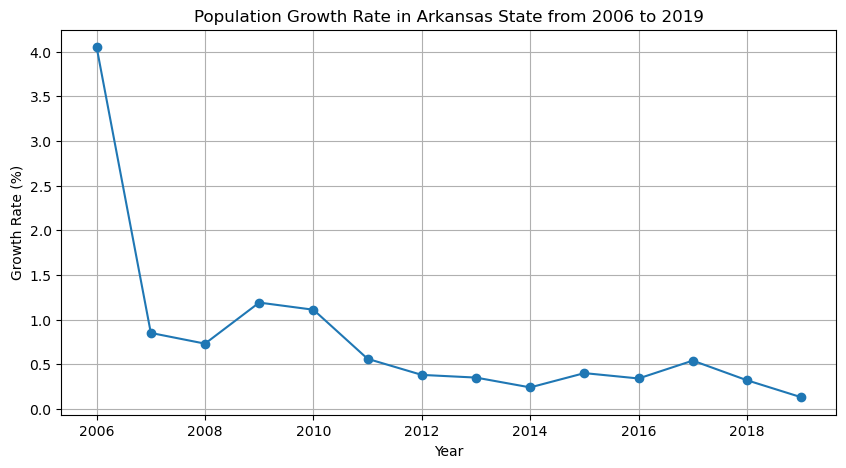

In [12]:
import matplotlib.pyplot as plt

year = [2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]
growth_rate_percent = [4.05, 0.85, 0.73, 1.19, 1.11, 0.56, 0.38, 0.35, 0.24, 0.40, 0.34, 0.54, 0.32, 0.13]

plt.figure(figsize=(10, 5))
plt.plot(year, growth_rate_percent, marker='o')
plt.title('Population Growth Rate in Arkansas State from 2006 to 2019')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.grid(True)
plt.show()

### Markdown Explanation

#### Markdown explanation: the population growth is at a peak in 2006 at 4%, and sharply declines. 
#### However, the rate slowly decreases from 2008 to 2019, reaching the lowest growth point of 0.13%. This decreasing growth rate was a steady decline, and shows that people weren't moving into Arkansas, having kids, or people were dying. 

# Q2- Income and Population Relationship

In [13]:
sql_2 = """
SELECT
    P.year,
    S.name AS state_name,
    P.pop AS yearly_population,
    I.income AS annual_income
FROM
    population AS P
INNER JOIN
    income AS I
    ON P.fips = I.fips AND P.year = I.year 
INNER JOIN
    name AS S 
    ON P.fips = S.fips
WHERE
    S.name = 'Arkansas'
ORDER BY
    P.year ASC
    """

#### importing data from SQL

In [14]:
ar_df2 = pd.read_sql(sql_2, con=conn)
ar_df2.head() 

/tmp/ipykernel_20756/1857416668.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ar_df2 = pd.read_sql(sql_2, con=conn)


,year,state_name,yearly_population,annual_income
0,2005,Arkansas,2701431,34999
1,2006,Arkansas,2810872,36599
2,2007,Arkansas,2834797,38134
3,2008,Arkansas,2855390,38815
4,2009,Arkansas,2889450,37823


#### read the data in, show the top 5 rows

#### below, using AI to help code in a visualization

In [15]:
%%ai gpt4
use the data in {ar_df2},create a dual-axis chart in Python with Jupyter AI’s help:
o X-axis = year
o Left Y-axis = population (line)
o Right Y-axis = median household income (bar or line, different color)
• Chart must include the state name in the title.
 

Here is a Python code snippet that uses `matplotlib` to create a dual-axis chart:

```python
import matplotlib.pyplot as plt

year = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
population = [2701431, 2810872, 2834797, 2855390, 2889450, 2921606, 2937979, 2949131, 2959373, 2966369, 2978204, 2988248, 3004279, 3013825, 3017804]
income = [34999, 36599, 38134, 38815, 37823, 38307, 38758, 40112, 40511, 41262, 41995, 44334, 45869, 47062, 48952]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Population', color=color)
ax1.plot(year, population , color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Median Household Income', color=color)
ax2.plot(year, income,  marker='o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Population and Median Household Income in Arkansas (2005-2019)')
plt.show()
```

Be sure to run this code in a Python environment in order to generate the dual-axis chart.

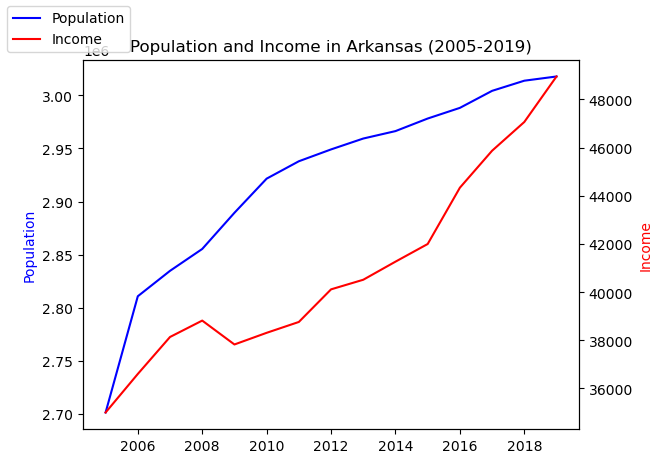

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame
df = pd.DataFrame({
    'Year': [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
    'Population': [2701431, 2810872, 2834797, 2855390, 2889450, 2921606, 2937979, 2949131, 2959373, 2966369, 2978204, 2988248, 3004279, 3013825, 3017804],
    'Income': [34999, 36599, 38134, 38815, 37823, 38307, 38758, 40112, 40511, 41262, 41995, 44334, 45869, 47062, 48952]
})

# Create a dual-axis figure
fig, ax1 = plt.subplots()

# Plot Population
ax1.plot(df['Year'], df['Population'], color = 'blue', label = 'Population')
ax1.set_ylabel('Population', color = 'blue')

# Instantiate a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot Income 
ax2.plot(df['Year'], df['Income'], color = 'red', label = 'Income')
ax2.set_ylabel('Income', color = 'red')

# Set title
plt.title('Population and Income in Arkansas (2005-2019)')

# Show the plot with legend
fig.legend(loc="upper left")
plt.show()

#### Markdown explanation: The population and income trends compare because the median income and the population in Arkansas have observed a growing trend from 2005 to 2019. 
#### However, the population is a steady increase, but the income increase/growth is more of an irregular increase. So, as more people existed, the median income didn't really reflect a similarly trending increase. 

## Q3- What is the annual growth rate of the population for the past 10 years?

#### load in SQL

In [24]:
sql_3 = """
SELECT
    P.year,
    P.pop,
    (P.pop - LAG(P.pop) OVER (ORDER BY P.year)) * 100.0 / LAG(P.pop) OVER (ORDER BY P.year) AS annual_growth_rate_percent
FROM
    population AS P
INNER JOIN
    name AS S
    ON P.fips = S.fips
WHERE
    S.name = 'Arkansas'
    AND P.year BETWEEN 2010 AND 2019
ORDER BY
    P.year ASC
    """

#### read in data and show the first 5 rows

In [26]:
ar_df3 = pd.read_sql(sql_3, con=conn)
ar_df3.head() 

/tmp/ipykernel_20756/2927227325.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ar_df3 = pd.read_sql(sql_3, con=conn)


,year,pop,annual_growth_rate_percent
0,2010,2921606,NaN
1,2011,2937979,0.560411
2,2012,2949131,0.379581
3,2013,2959373,0.347289
4,2014,2966369,0.236401


#### ai to help make a chart of data

In [28]:
%%ai gpt4
use the data from {ar_df3}, make a chart visualizing the annual growth rate of the population for the past 10 years . make sure to include the state name Arkansas in the title of the chart

Here's the chart visualization in Python. Replace the \`python\` with your specific language if necessary.

```python
import matplotlib.pyplot as plt

# Actual data
years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
annual_growth_rate_percent = [None, 0.560411, 0.379581, 0.347289, 0.236401, 0.398973, 0.337250, 0.536468, 0.317747, 0.132025]

plt.plot(years, annual_growth_rate_percent, marker='o')
plt.title('Annual Population Growth Rate in Arkansas (2010-2019)')
plt.xlabel('Year')
plt.ylabel('Annual Growth Rate (%)')
plt.ylim(bottom=0)  # Set the bottom ylim to 0
plt.grid()
plt.show()
```
In this chart, the x-axis represents the year and the y-axis represents the annual population growth rate in percentages. The line with markers shows the annual growth rate in Arkansas from 2010 to 2019.

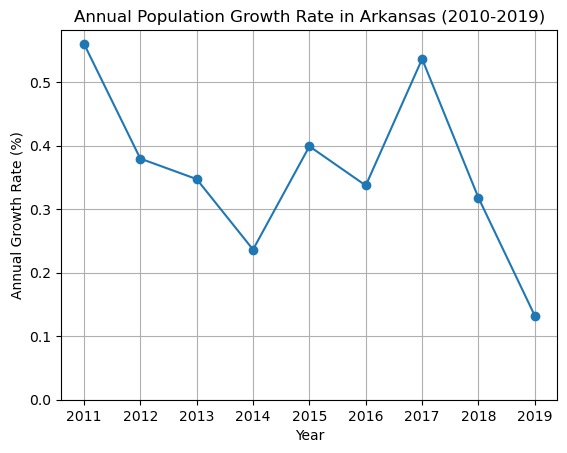

In [29]:
import matplotlib.pyplot as plt

# Actual data
years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
annual_growth_rate_percent = [None, 0.560411, 0.379581, 0.347289, 0.236401, 0.398973, 0.337250, 0.536468, 0.317747, 0.132025]

plt.plot(years, annual_growth_rate_percent, marker='o')
plt.title('Annual Population Growth Rate in Arkansas (2010-2019)')
plt.xlabel('Year')
plt.ylabel('Annual Growth Rate (%)')
plt.ylim(bottom=0)  # Set the bottom ylim to 0
plt.grid()
plt.show()

#### Markdown explanation: from 2010-2019, the annual population growth fluctuates in Arkansas. In the earlyy 2010s, it decreases, meaning that people either died or moved away, but the growth rate increases from 2015 and peaks in 2017, decreasing again toward 2019. People are moving in and out of Arkansas in the 2010s, and it would be interesting to examine the underlying socioeconomic trends going on in these years to see if they had any impact on these population trends. 